### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Mon Sep 30 15:52:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [1]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [3]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.73 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.0/112.6 GB disk)


**NOTE:** When training YOLO11, make sure your data is located in `{HOME}/datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. When downloading data from [Roboflow Universe](https://universe.roboflow.com/), use the YOLOv8 format.

In [2]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="39vHOefgqvRZFcX7fTWp")
project = rf.workspace("amazonml-btsee").project("cavity-c3ytj-opynq-anr68")
version = project.version(1)
dataset = version.download("yolov11")



mkdir: cannot create directory ‘/content/datasets’: File exists
/content/datasets
loading Roboflow workspace...
loading Roboflow project...


**NOTE:** Make sure to run commands below to make dataset work with YOLO11 training.

In [3]:
!sed -i '$d' {dataset.location}/data.yaml   # Delete the last line
!sed -i '$d' {dataset.location}/data.yaml   # Delete the second-to-last line
!sed -i '$d' {dataset.location}/data.yaml   # Delete the third-to-last line

!echo 'test: ../test/images' >> {dataset.location}/data.yaml
!echo 'train: ../train/images' >> {dataset.location}/data.yaml
!echo 'val: ../valid/images' >> {dataset.location}/data.yaml

## Custom Training

In [4]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=10 imgsz=640 plots=True

/content
100% 18.4M/18.4M [00:00<00:00, 244MB/s]
Ultralytics 8.3.73 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/datasets/cavity-1/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, sa

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [5]:
!ls {HOME}/runs/detect/train/

args.yaml					    labels.jpg	  train_batch0.jpg
confusion_matrix_normalized.png			    P_curve.png   train_batch1.jpg
confusion_matrix.png				    PR_curve.png  train_batch2.jpg
events.out.tfevents.1738938314.9aaf6fafc95e.2983.0  R_curve.png   val_batch0_labels.jpg
F1_curve.png					    results.csv   val_batch0_pred.jpg
labels_correlogram.jpg				    results.png   weights


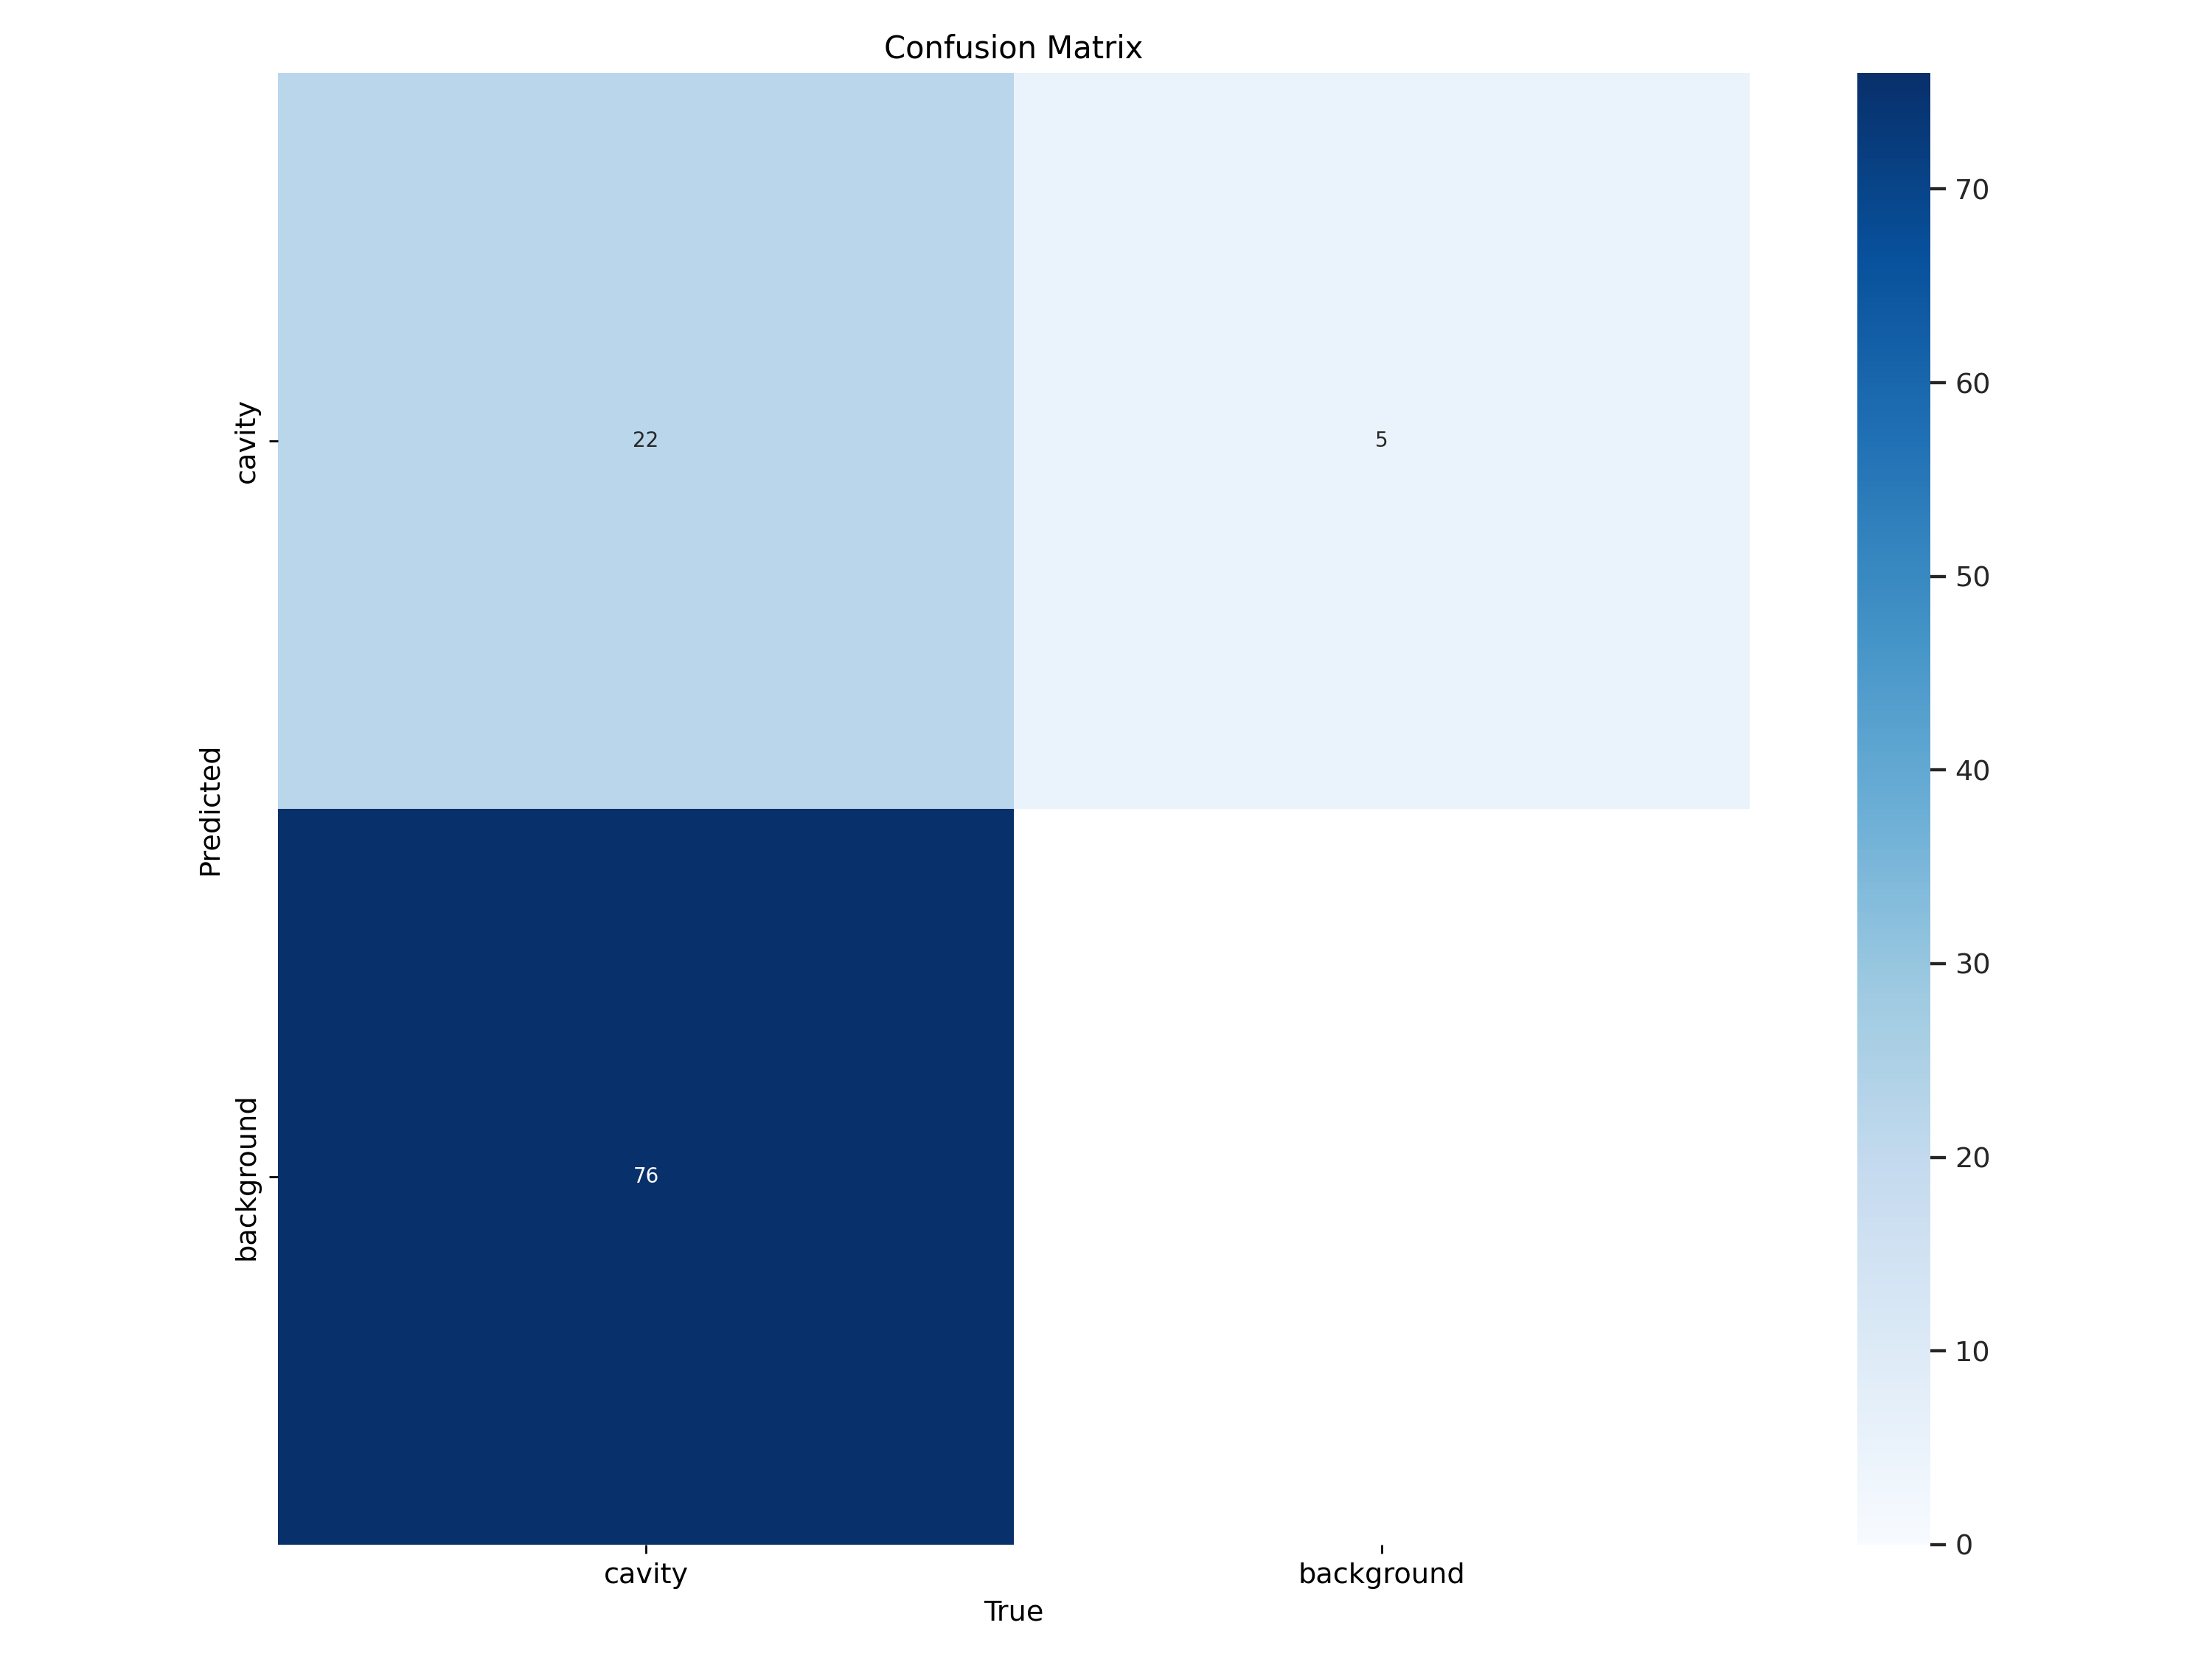

In [6]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

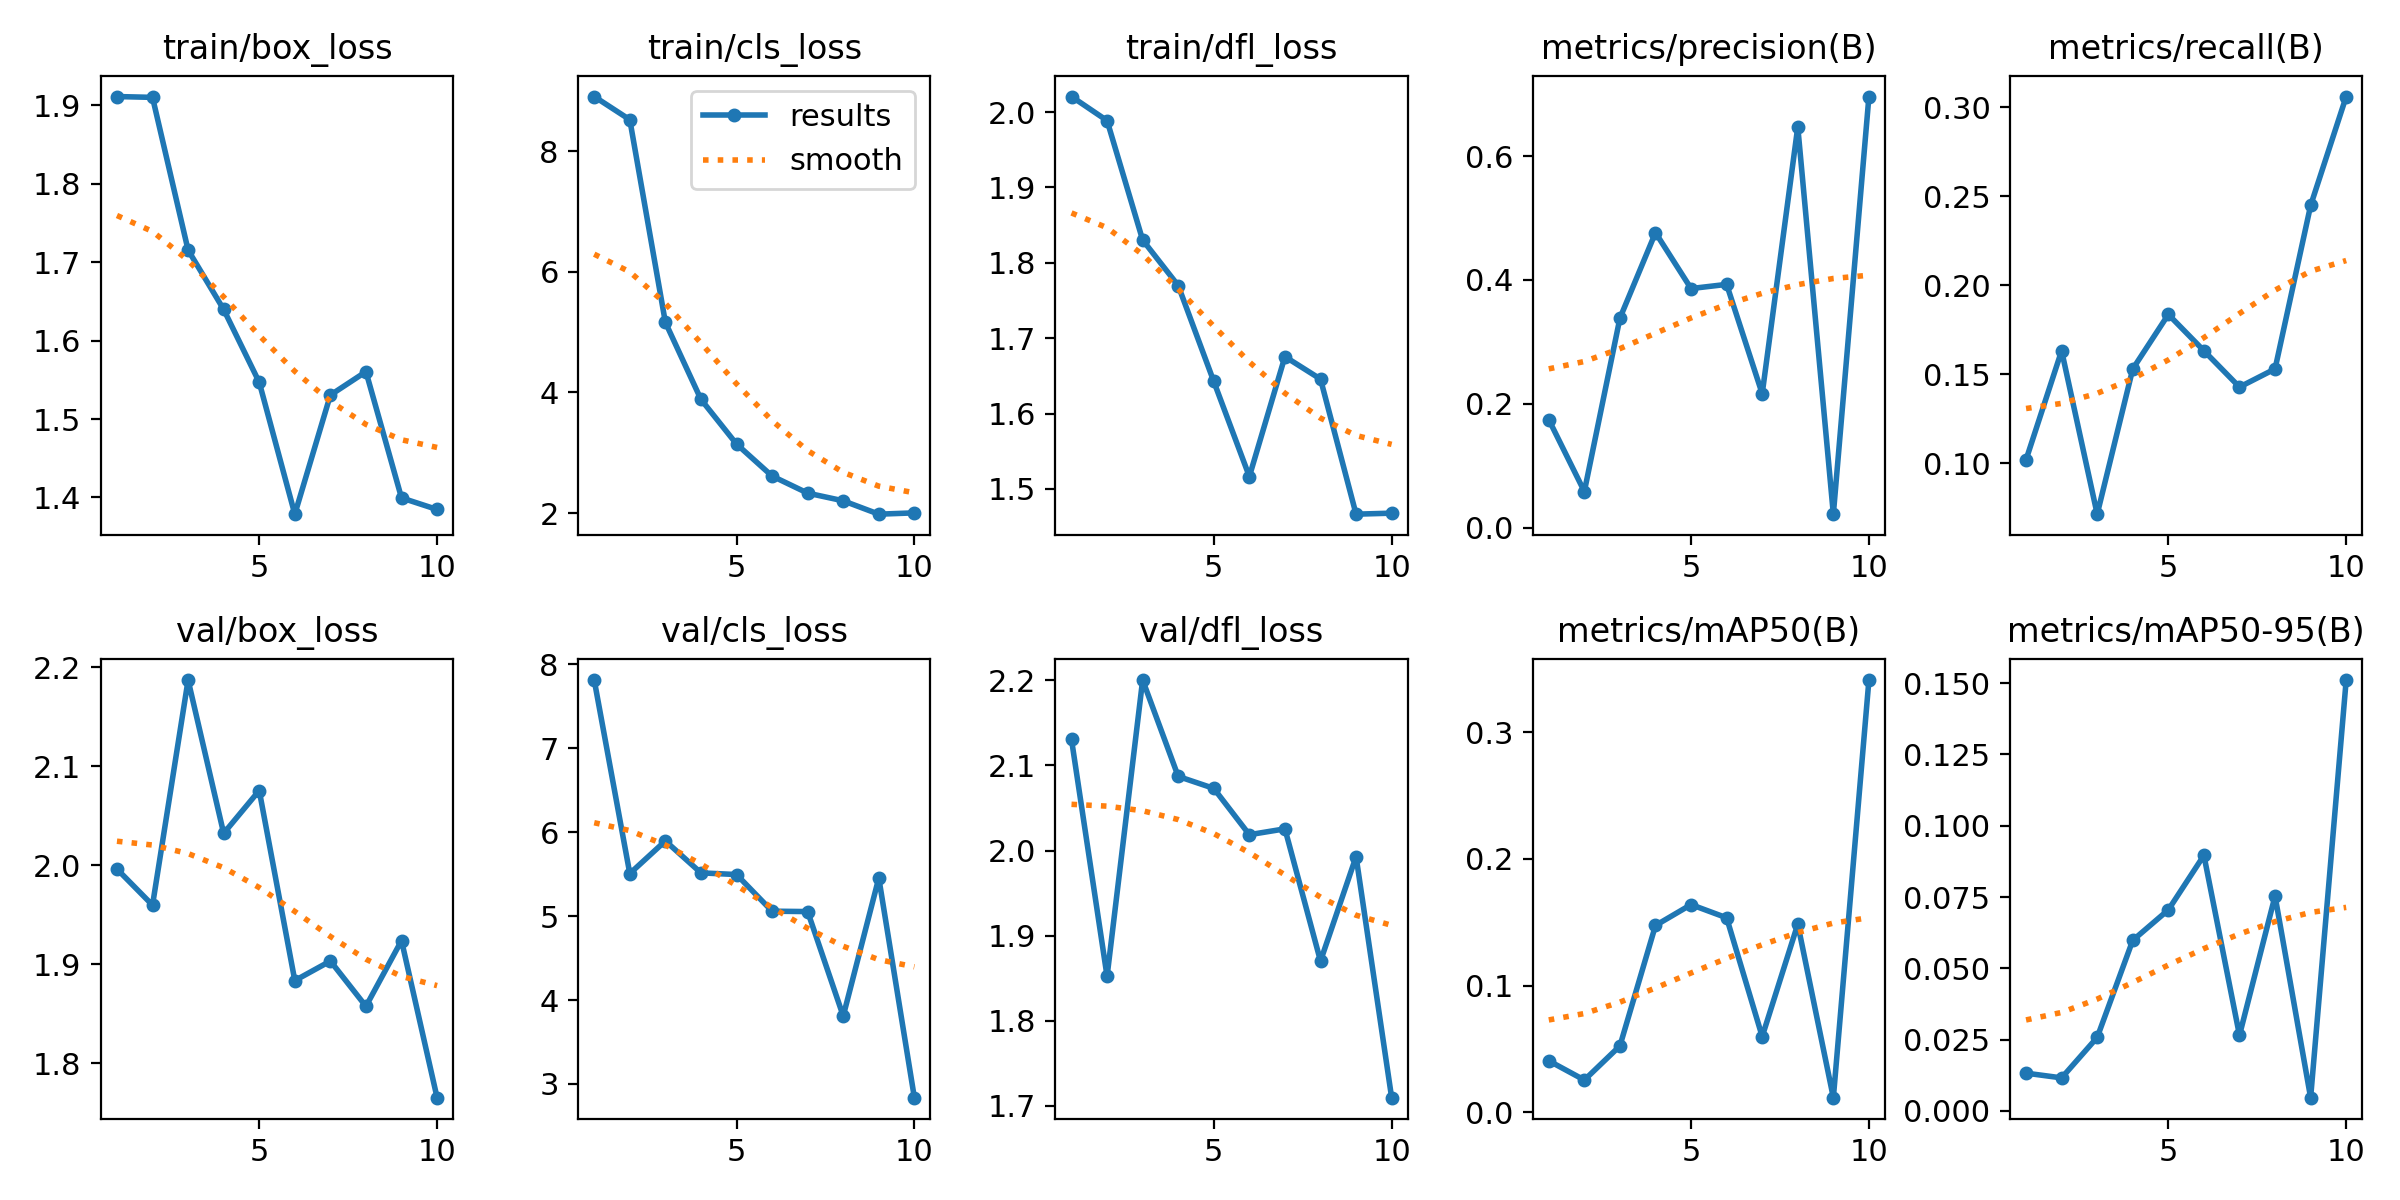

In [7]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

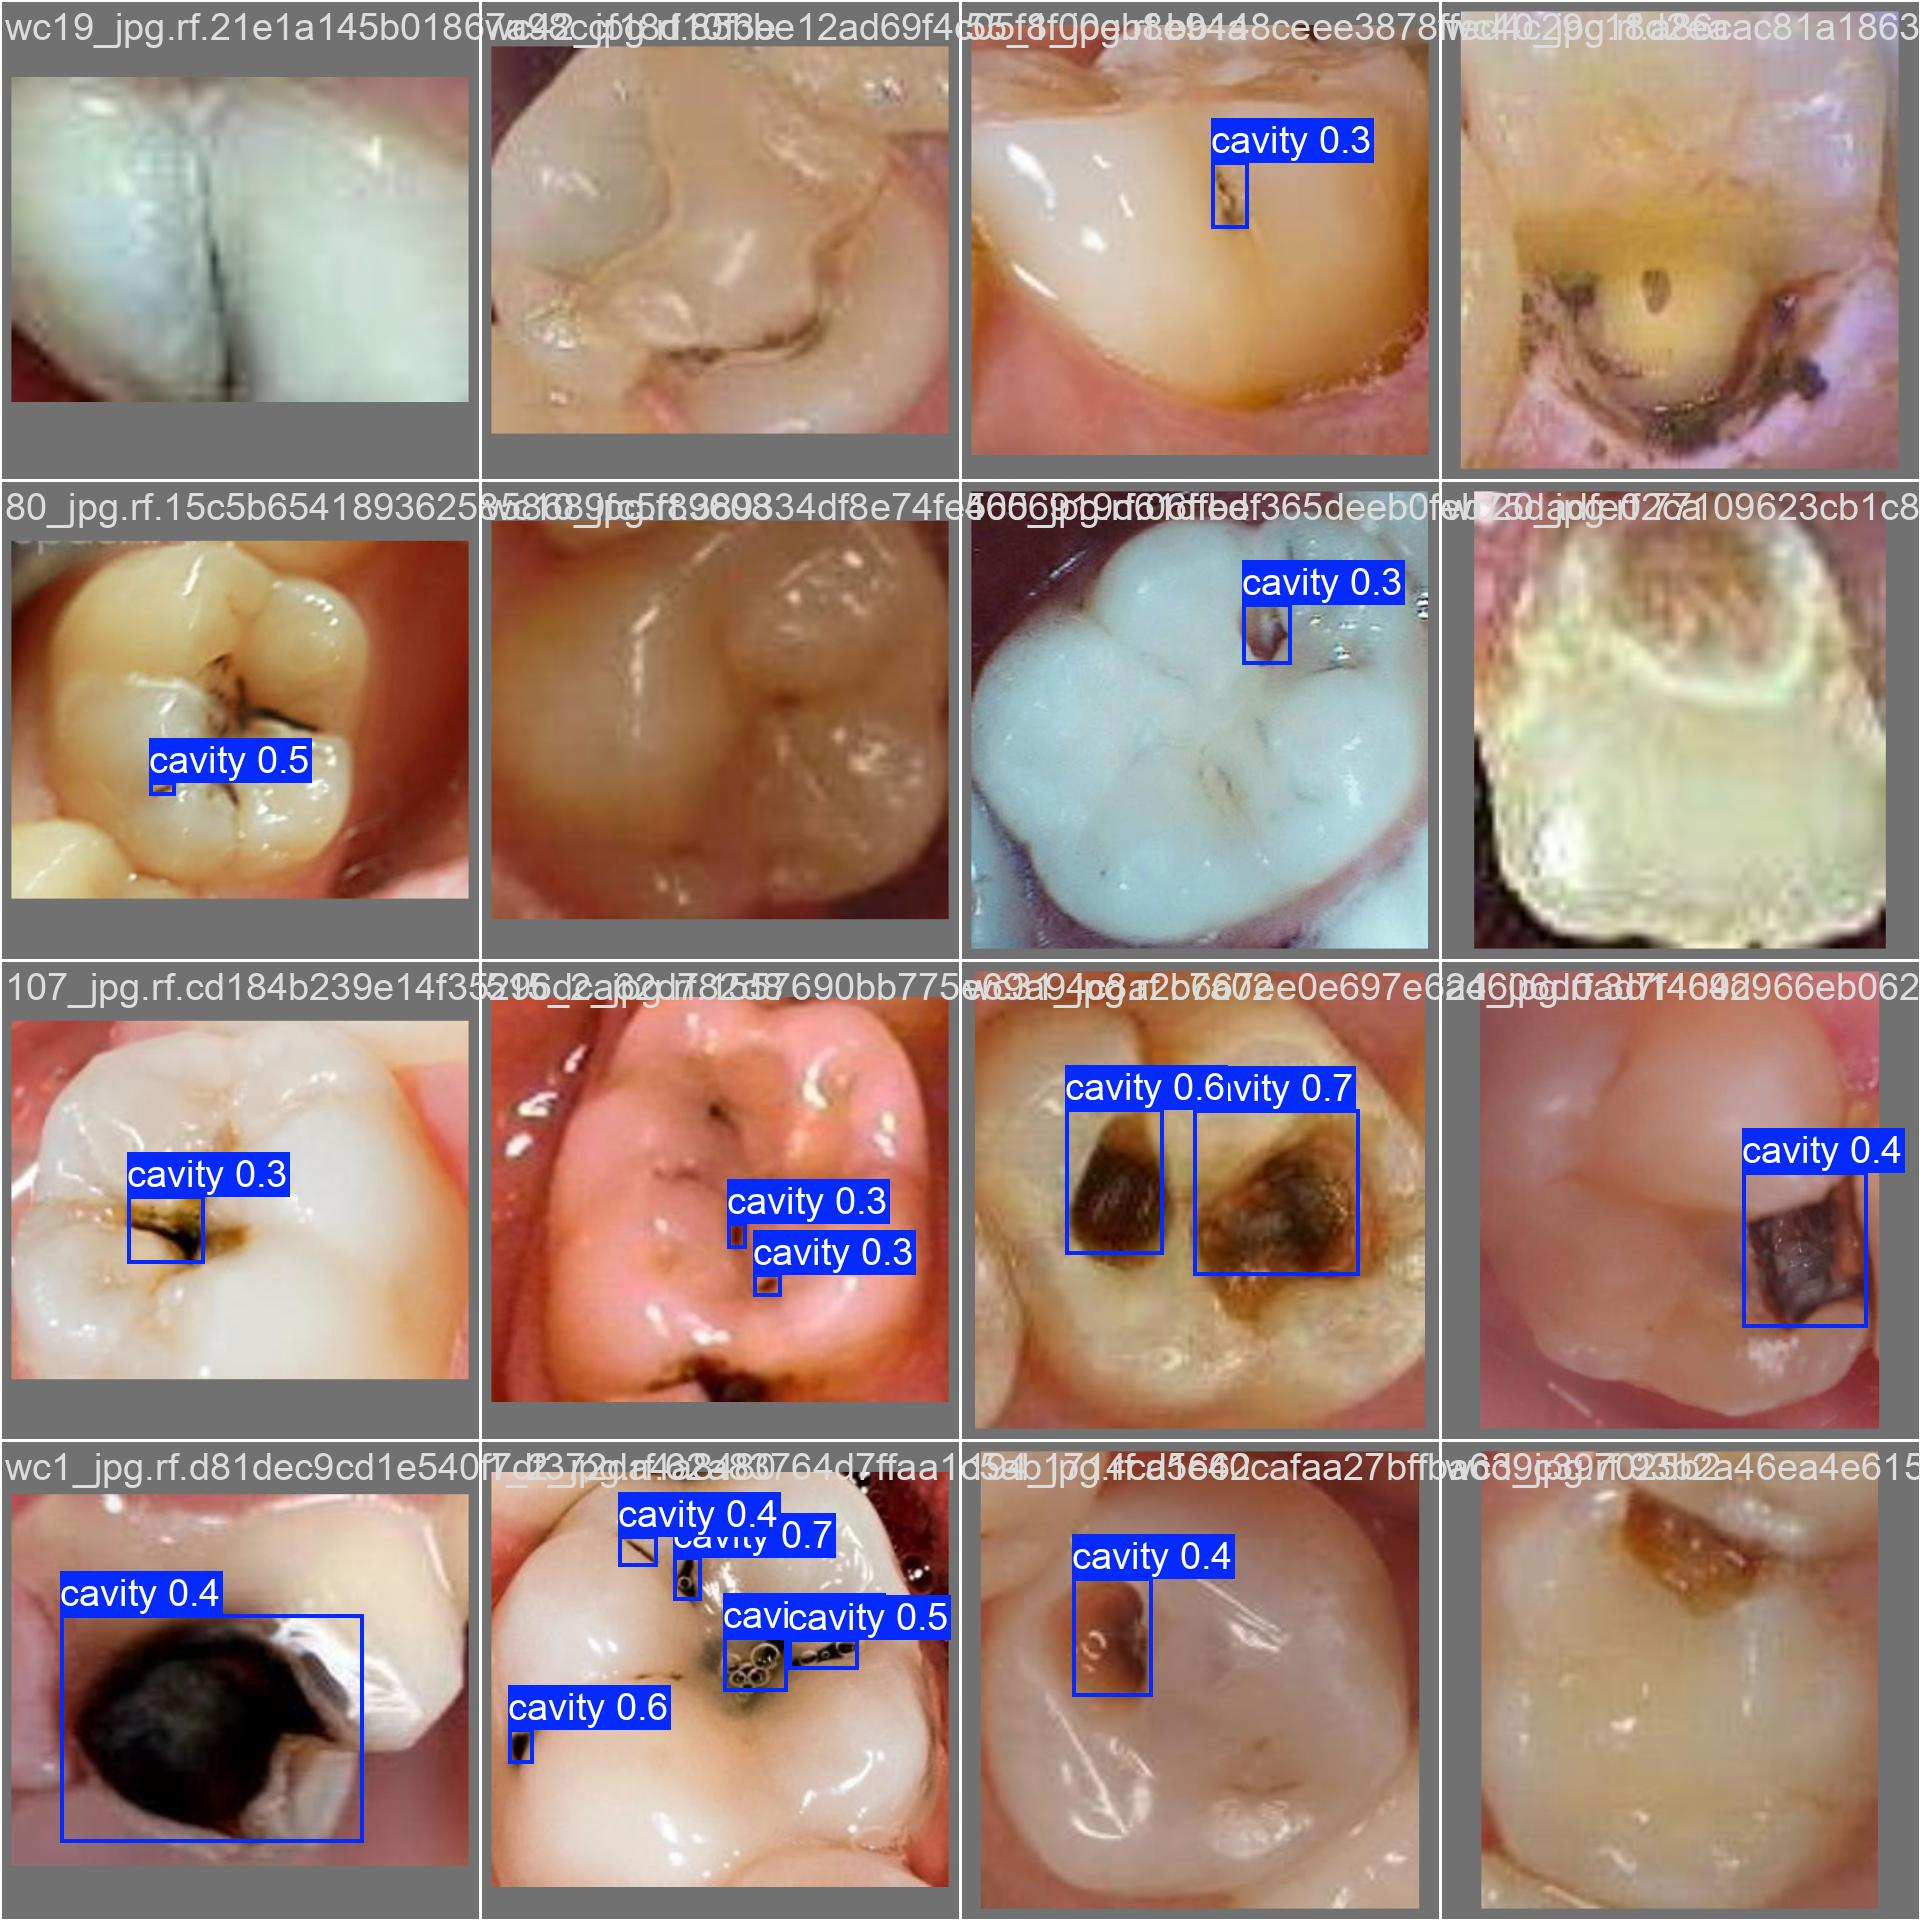

In [8]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [9]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.73 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /content/datasets/cavity-1/valid/labels.cache... 27 images, 0 backgrounds, 0 corrupt: 100% 27/27 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 2/2 [00:01<00:00,  1.66it/s]
                   all         27         98      0.593      0.296      0.334      0.153
Speed: 5.4ms preprocess, 14.4ms inference, 0.0ms loss, 14.7ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


## Inference with custom model

In [10]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.73 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs

image 1/13 /content/datasets/cavity-1/test/images/10_jpg.rf.0d1d7241de762a90675a61cfa1b4d2b6.jpg: 640x640 3 cavitys, 15.9ms
image 2/13 /content/datasets/cavity-1/test/images/13_jpg.rf.ad729bbe836a1a9c6ea35299e3c46cd5.jpg: 608x640 (no detections), 47.5ms
image 3/13 /content/datasets/cavity-1/test/images/226_jpg.rf.8dec1c696aee0c6992fa49cea21c34db.jpg: 640x640 1 cavity, 16.3ms
image 4/13 /content/datasets/cavity-1/test/images/370_5_jpg.rf.2f3d38fef8f4f4462b87dc4bc9d255cc.jpg: 640x352 1 cavity, 44.0ms
image 5/13 /content/datasets/cavity-1/test/images/523_1_jpg.rf.7a9cc16623e9e7a7be1ee128c49abc90.jpg: 640x416 (no detections), 47.6ms
image 6/13 /content/datasets/cavity-1/test/images/523_jpg.rf.eed22e20b35e6f1339015f6c39b2051b.jpg: 640x544 (no detections), 46.0ms
image 7/13 /content/datasets/cavity-1/test/images/526_jpg.rf.bbd4

**NOTE:** Let's take a look at few results.

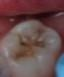

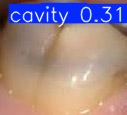

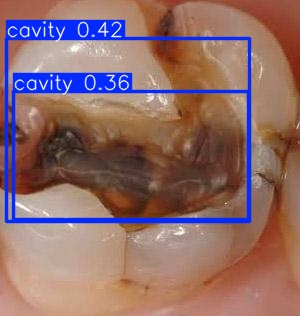

In [11]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob('/content/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")